In [1]:
import tensorflow as tf

keras = tf.keras
import pandas as pd, numpy as np
import os, unidecode, glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = (15, 8)

import math
from sklearn.metrics import mean_squared_error

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
check_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.path.dirname(os.getcwd())+'\\filtered_data\\checkin\\*.parquet')], ignore_index=True)

check_df['date'] = check_df.date.apply(lambda x: x.split(','))
check_df = check_df.explode('date').reset_index().drop('index',axis=1)
check_df['date'] = pd.to_datetime(check_df.date)

In [4]:
bus_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.path.dirname(os.getcwd())+'\\filtered_data\\business\\*.parquet')], ignore_index=True)

bus_df['city'] = bus_df.city.apply(lambda x: unidecode.unidecode(x))
bus_df['state'] = np.select(
    [
        bus_df['city'].isin(['Toronto', 'Richmond Hill', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']),
        bus_df['city'].isin(['Calgary']),
        bus_df['city'].isin(['Montreal']),
    ],
    [
        'ON',
        'AB',
        'QC'
    ]
)

In [5]:
df = bus_df[['business_id','city']].merge(check_df,on=['business_id'],how='inner')
df['city'] = df.city.astype('category')
df = df.assign(date=df.date.dt.round('H'))
df.head()

,business_id,city,date
0,EosRKXIGeSWFYWwpkbhNnA,Toronto,2012-06-12 19:00:00
1,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-11 15:00:00
2,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-02-22 18:00:00
3,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-05 21:00:00
4,EosRKXIGeSWFYWwpkbhNnA,Toronto,2013-03-06 17:00:00


In [6]:
pivot_df = df.pivot_table(index='date',values='business_id',columns='city',aggfunc='count', fill_value=0)
pivot_df.index = pd.DatetimeIndex(pivot_df.index)
pivot_df

city,Brampton,Calgary,Markham,Mississauga,Montreal,North York,Richmond Hill,Scarborough,Toronto,Vaughan
date,,,,,,,,,,
2010-01-16 02:00:00,0,1,0,0,0,0,0,0,0,0
2010-01-16 05:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 10:00:00,0,0,0,0,0,0,0,0,2,0
2010-01-16 13:00:00,0,0,0,0,0,0,0,0,1,0
2010-01-16 15:00:00,0,1,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-13 13:00:00,0,0,0,0,0,1,1,0,4,0
2019-12-13 14:00:00,0,0,0,0,0,0,1,0,4,0
2019-12-13 15:00:00,0,0,3,1,2,0,0,0,5,0


In [7]:
daily_tor = pivot_df.loc[:,'Toronto'].resample('D').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')

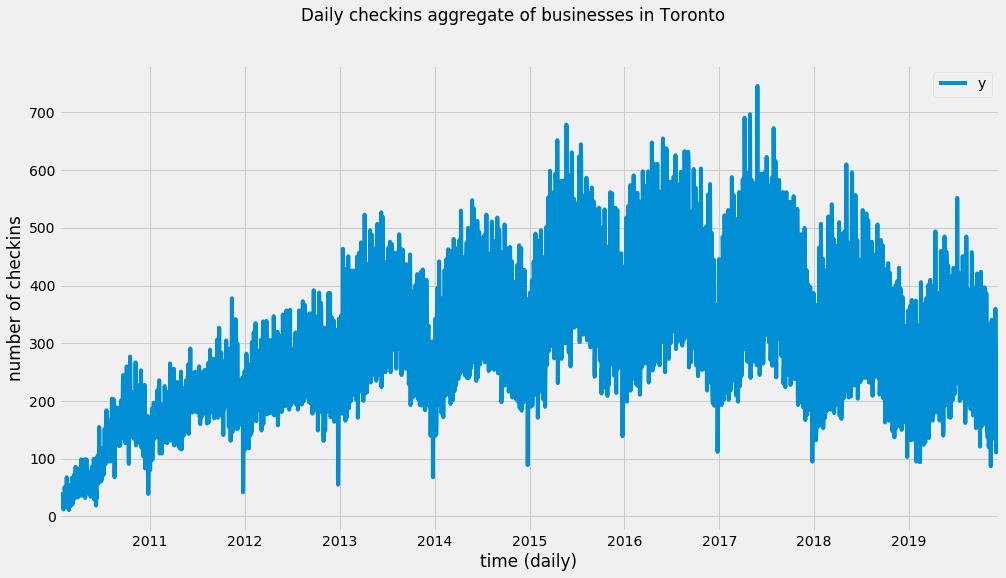

In [8]:
fig, ax = plt.subplots()
daily_tor.plot(ax=ax)
fig.suptitle('Daily checkins aggregate of businesses in Toronto')
ax.set(xlabel='time (daily)',ylabel=('number of checkins'))
plt.legend()
plt.show()

## Forecasting

In [9]:
def train_test_split(ts_df):
    test_split = '2019-01-01'
    train = ts_df.loc[ts_df.index < test_split].copy()
    test = ts_df.loc[(ts_df.index >= test_split)].copy()
    print(train.shape)
    print(test.shape)
    return (train,test)

d_train, d_test = train_test_split(daily_tor.loc[daily_tor.index > '2012-12-31'])
val_size = d_test.shape[0]
error_vals = list()

(2191, 1)
(347, 1)


In [10]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
ts_model_path = os.path.dirname(os.getcwd())+'\\saved_models\\time_series'
if not os.path.exists(ts_model_path):
    os.makedirs(ts_model_path)

### Simple stateless RNN

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 15
train_set = window_dataset(d_train[:-1*val_size].y, window_size, batch_size=128)
valid_set = window_dataset(d_train[-1*val_size:].y, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(ts_model_path,"rnn_checkpoint"), save_best_only=True)
model.fit(train_set, epochs=250,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/250
     15/Unknown - 2s 157ms/step - loss: 175.4382 - mae: 177.5110WARNING:tensorflow:From I:\Installed\anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: g:\GitHub\YELP Merchant Dashboard local\saved_models\time_series\rnn_checkpoint\assets
15/15 [==============================] - 8s 555ms/step - loss: 175.5365 - mae: 177.5110 - val_loss: 153.5739 - val_mae: 153.2370
Epoch 2/250
15/15 [==============================] - 6s 421ms/step - loss: 97.8448 - mae: 98.8022 - val_loss: 85.9277 - val_mae: 86.3900
Epoch 3/250
15/15 [==============================] - 1s 39ms/step - loss: 86.2251 - mae: 86.7722 - val_loss: 91.0975 - val_mae: 92.1322
Epoch 4/250
15/15 [=================

In [14]:
rnn_model = keras.models.load_model(os.path.join(ts_model_path,"rnn_checkpoint"))

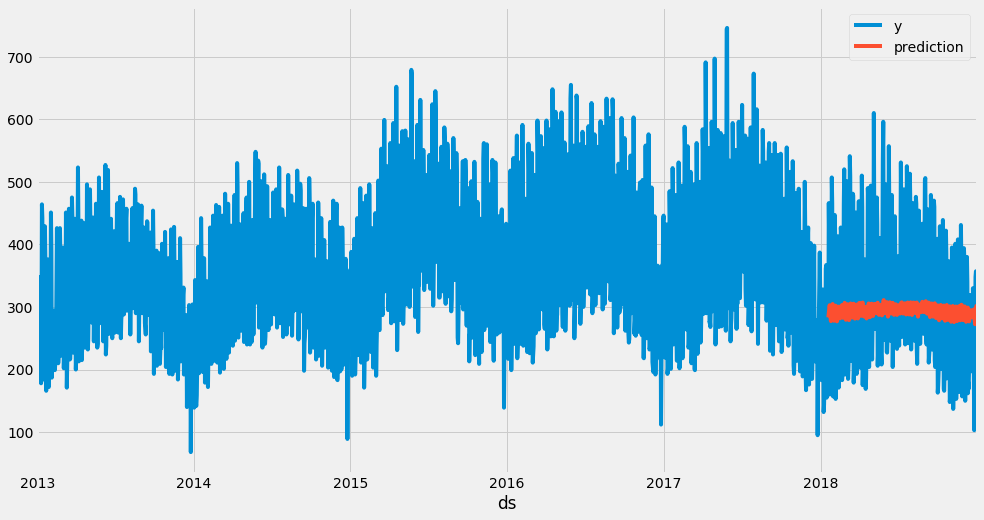

In [15]:
rnn_predict = model_forecast(rnn_model, d_train[-val_size-window_size:-1].y, window_size)[:, 0]
pred = pd.DataFrame(rnn_predict, \
            index=d_train[-val_size:].index,
            columns=['prediction'])

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [16]:
rmse_train = math.sqrt(mean_squared_error(d_train[-val_size:], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 101.08157492231327.


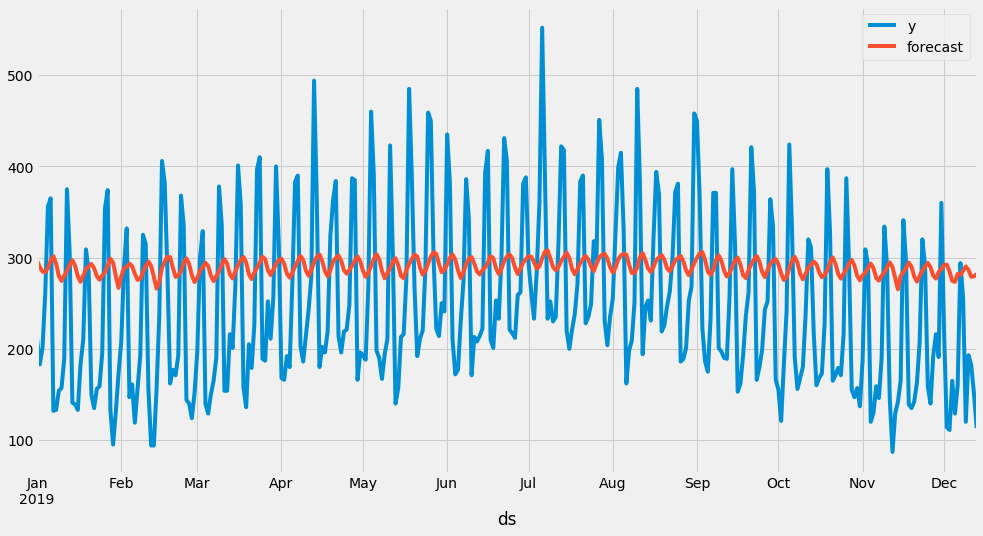

In [17]:
rnn_forecast = model_forecast(rnn_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y, window_size)[:, 0]
fcast = pd.DataFrame(rnn_forecast, \
            index=d_test.index,
            columns=['forecast'])

fig, ax = plt.subplots()
d_test.plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [18]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 100.70274761854024.


In [19]:
mape = np.mean(np.abs(d_test.y.values - fcast.forecast.values) / d_test.y.values) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 45.74767639287863.


In [20]:
error_vals.append(('Stateless RNN',rmse_train,rmse_test,mape))

### Sequence to sequence forecasting

In [21]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 15
train_set = seq2seq_window_dataset(d_train[:-1*val_size].y, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(d_train[-1*val_size:].y, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(ts_model_path,"s2s_checkpoint"), save_best_only=True)
model.fit(train_set, epochs=250,
          validation_data=valid_set,
          callbacks=[early_stopping,model_checkpoint])

Epoch 1/250
     15/Unknown - 3s 207ms/step - loss: 190.1465 - mae: 193.4750INFO:tensorflow:Assets written to: g:\GitHub\YELP Merchant Dashboard local\saved_models\time_series\s2s_checkpoint\assets
15/15 [==============================] - 12s 799ms/step - loss: 190.3233 - mae: 193.4750 - val_loss: 160.3115 - val_mae: 160.9527
Epoch 2/250
15/15 [==============================] - 8s 546ms/step - loss: 106.3963 - mae: 107.4516 - val_loss: 84.7534 - val_mae: 85.2811
Epoch 3/250
15/15 [==============================] - 1s 54ms/step - loss: 90.8888 - mae: 91.5043 - val_loss: 89.7694 - val_mae: 90.5084
Epoch 4/250
15/15 [==============================] - 8s 560ms/step - loss: 87.6720 - mae: 88.1112 - val_loss: 84.0533 - val_mae: 84.7671
Epoch 5/250
15/15 [==============================] - 1s 54ms/step - loss: 85.5606 - mae: 86.0821 - val_loss: 93.0225 - val_mae: 93.5814
Epoch 6/250
15/15 [==============================] - 1s 55ms/step - loss: 85.5569 - mae: 86.1416 - val_loss: 90.7980 - val_m

In [23]:
s2s_model = keras.models.load_model(os.path.join(ts_model_path,"s2s_checkpoint"))

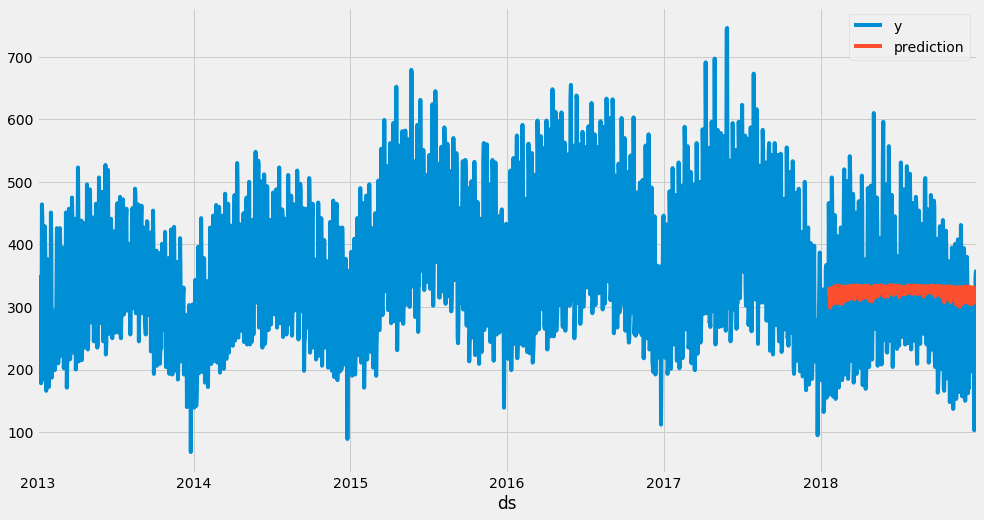

In [24]:
s2s_predict = model_forecast(s2s_model, d_train.y.values[-val_size-window_size:-1][..., np.newaxis], window_size)[:, 0]
pred = pd.DataFrame(s2s_predict, \
            index=d_train[-val_size:].index,
            columns=['prediction'])

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [25]:
rmse_train = math.sqrt(mean_squared_error(d_train[-val_size:], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 102.28750562830767.


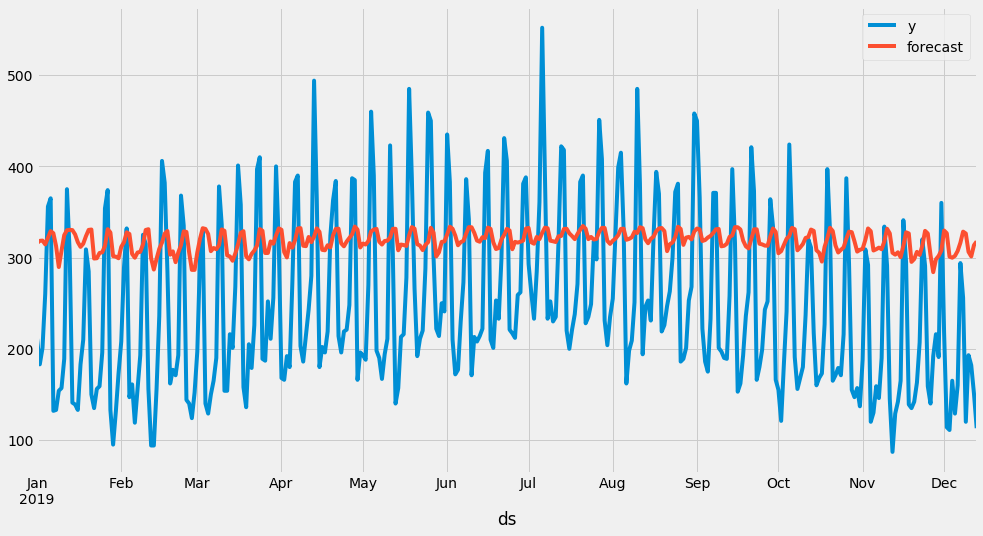

In [26]:
s2s_forecast = model_forecast(s2s_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y.values[..., np.newaxis], window_size)[:, 0]
fcast = pd.DataFrame(s2s_forecast, \
            index=d_test.index,
            columns=['forecast'])

fig, ax = plt.subplots()
d_test.plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [27]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 113.6046273572684.


In [28]:
mape = np.mean(np.abs(d_test.y.values - fcast.forecast.values) / d_test.y.values) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 53.94538500551942.


In [29]:
error_vals.append(('Sequence-to-sequence',rmse_train,rmse_test,mape))

### Stateful RNN

In [30]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [31]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(d_train[:-val_size].y, window_size)
valid_set = sequential_window_dataset(d_train[-val_size:].y, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(ts_model_path,"srnn_checkpoint.h5"), save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=20)
model.fit(train_set, epochs=250,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/250
61/61 [==============================] - 8s 133ms/step - loss: 109.3029 - mae: 109.8022 - val_loss: 102.1950 - val_mae: 102.6950
Epoch 2/250
61/61 [==============================] - 5s 76ms/step - loss: 86.4025 - mae: 86.9021 - val_loss: 96.3573 - val_mae: 96.8573
Epoch 3/250
61/61 [==============================] - 5s 75ms/step - loss: 85.2877 - mae: 85.7869 - val_loss: 96.0374 - val_mae: 96.5374
Epoch 4/250
61/61 [==============================] - 5s 75ms/step - loss: 84.7269 - mae: 85.2259 - val_loss: 92.7906 - val_mae: 93.2906
Epoch 5/250
61/61 [==============================] - 5s 78ms/step - loss: 83.0905 - mae: 83.5897 - val_loss: 92.2381 - val_mae: 92.7381
Epoch 6/250
61/61 [==============================] - 4s 68ms/step - loss: 82.4249 - mae: 82.9239 - val_loss: 91.4593 - val_mae: 91.9593
Epoch 7/250
61/61 [==============================] - 4s 65ms/step - loss: 85.2185 - mae: 85.7165 - val_loss: 95.0843 - val_mae: 95.5843
Epoch 8/250
61/61 [========================

In [33]:
srnn_model = keras.models.load_model(os.path.join(ts_model_path,"srnn_checkpoint.h5"))
srnn_model.reset_states()

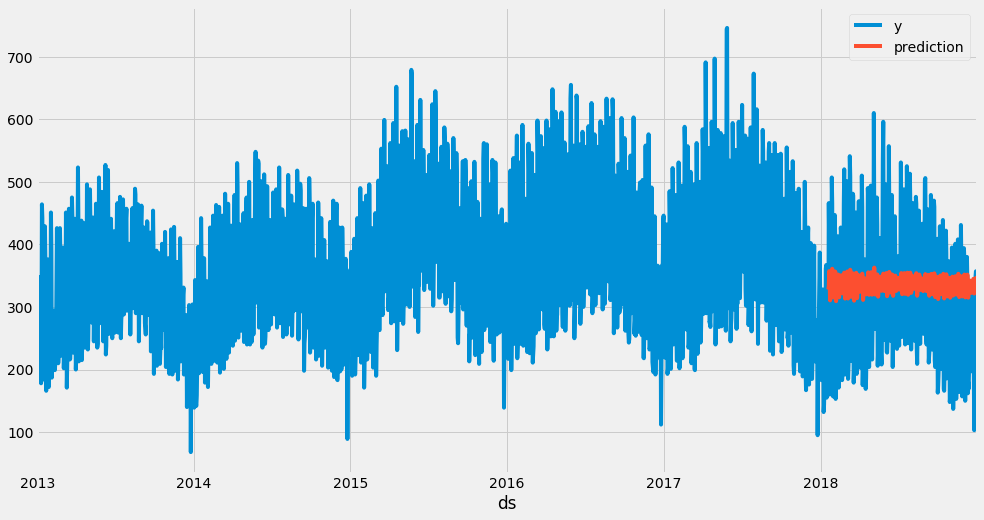

In [34]:
srnn_predict = srnn_model.predict(daily_tor.y.values[np.newaxis, :, np.newaxis])
pred = pd.DataFrame(srnn_predict[0, -2*val_size-1:-val_size-1, 0], \
            index=d_train[-val_size:].index,
            columns=['prediction'])

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [35]:
rmse_train = math.sqrt(mean_squared_error(d_train[-val_size:], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 103.75698337224433.


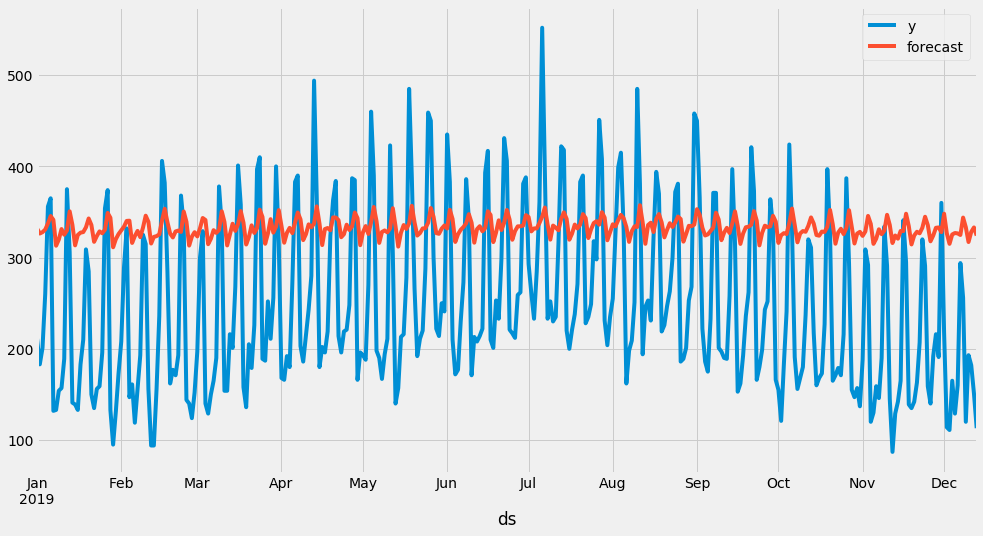

In [36]:
fcast = pd.DataFrame(srnn_predict[0, -val_size-1:-1, 0], \
            index=d_test.index,
            columns=['forecast'])

fig, ax = plt.subplots()
d_test.plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [37]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 122.29370487388718.


In [38]:
mape = np.mean(np.abs(d_test.y.values - fcast.forecast.values) / d_test.y.values) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 58.70767422744372.


In [39]:
error_vals.append(('Stateful RNN',rmse_train,rmse_test,mape))

### LSTM

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(d_train[:-val_size].y, window_size)
valid_set = sequential_window_dataset(d_train[-val_size:].y, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(ts_model_path,"lstm_checkpoint.h5"), save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
61/61 [==============================] - 9s 143ms/step - loss: 157.8625 - mae: 158.3623 - val_loss: 103.7798 - val_mae: 104.2780
Epoch 2/500
61/61 [==============================] - 1s 16ms/step - loss: 88.0344 - mae: 88.5325 - val_loss: 97.5009 - val_mae: 98.0009
Epoch 3/500
61/61 [==============================] - 1s 15ms/step - loss: 86.8611 - mae: 87.3604 - val_loss: 98.2263 - val_mae: 98.7263
Epoch 4/500
61/61 [==============================] - 1s 14ms/step - loss: 86.9559 - mae: 87.4546 - val_loss: 98.0985 - val_mae: 98.5985
Epoch 5/500
61/61 [==============================] - 1s 15ms/step - loss: 86.9061 - mae: 87.4048 - val_loss: 98.0638 - val_mae: 98.5638
Epoch 6/500
61/61 [==============================] - 1s 15ms/step - loss: 86.8697 - mae: 87.3683 - val_loss: 98.0279 - val_mae: 98.5279
Epoch 7/500
61/61 [==============================] - 1s 15ms/step - loss: 86.8216 - mae: 87.3202 - val_loss: 97.9914 - val_mae: 98.4914
Epoch 8/500
61/61 [========================

In [41]:
lstm_model = keras.models.load_model(os.path.join(ts_model_path,"lstm_checkpoint.h5"))
lstm_model.reset_states()

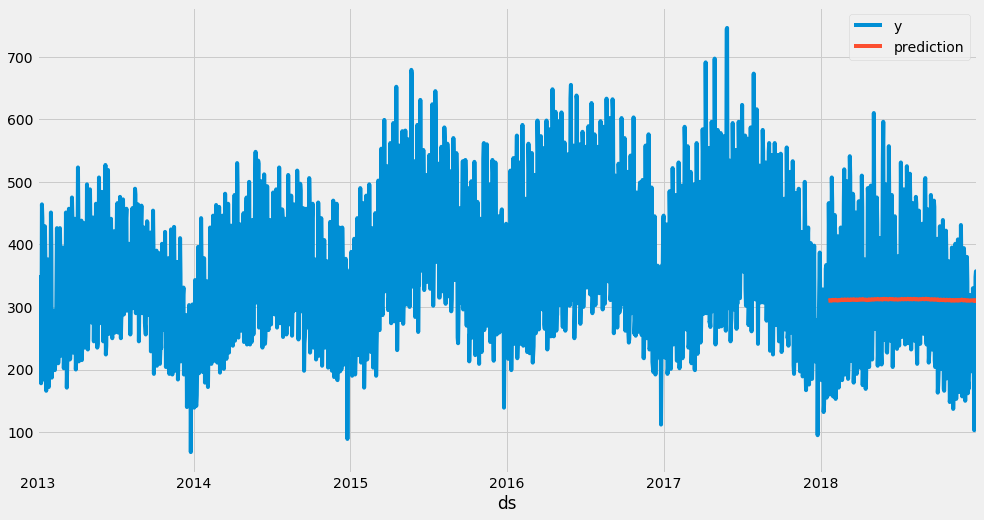

In [42]:
lstm_predict = lstm_model.predict(daily_tor.y.values[np.newaxis, :, np.newaxis])
pred = pd.DataFrame(lstm_predict[0, -2*val_size-1:-val_size-1, 0], \
            index=d_train[-val_size:].index,
            columns=['prediction'])

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [43]:
rmse_train = math.sqrt(mean_squared_error(d_train[-val_size:], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 103.67015961111781.


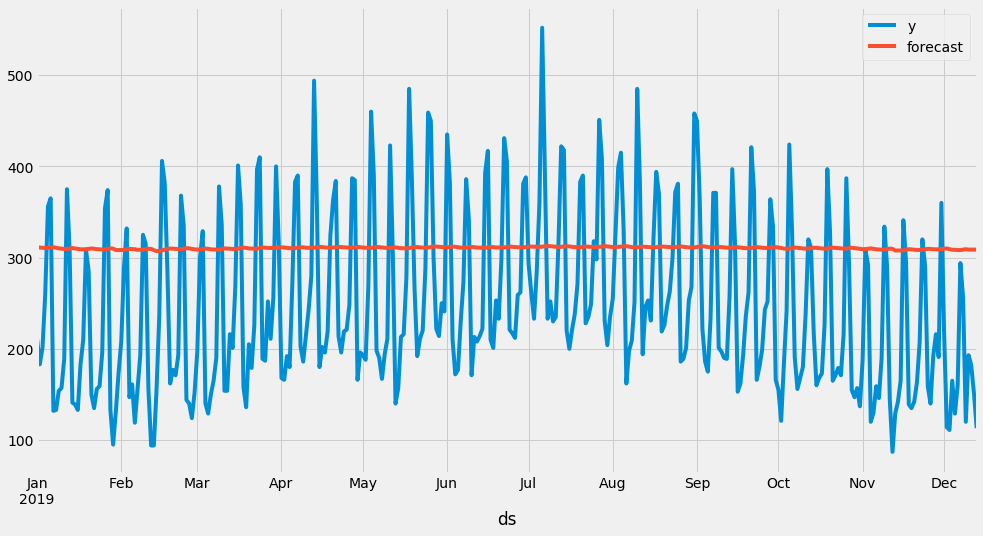

In [44]:
fcast = pd.DataFrame(lstm_predict[0, -val_size-1:-1, 0], \
            index=d_test.index,
            columns=['forecast'])

fig, ax = plt.subplots()
d_test.plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [45]:
rmse_test = math.sqrt(mean_squared_error(d_test, fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 112.53598226119604.


In [46]:
mape = np.mean(np.abs(d_test.y.values - fcast.forecast.values) / d_test.y.values) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 53.06400561372849.


In [47]:
error_vals.append(('LSTM',rmse_train,rmse_test,mape))

### LSTM - hourly data
- To understand the true value of LSTM cells for time series forecasting

In [48]:
hourly_tor = pivot_df.loc[:,'Toronto'].resample('H').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')
hval_size = hourly_tor.loc[hourly_tor.index >= '2019-01-01',:].shape[0]

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(hourly_tor[:-2*hval_size].y, window_size)
valid_set = sequential_window_dataset(hourly_tor[-2*hval_size:-hval_size].y, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(ts_model_path,"hourly_lstm_checkpoint.h5"), save_best_only=True)
model.fit(train_set, epochs=15,
          validation_data=valid_set,
          callbacks=[model_checkpoint, reset_states])

Epoch 1/15
2340/2340 [==============================] - 59s 25ms/step - loss: 4.3984 - mae: 4.8655 - val_loss: 4.5452 - val_mae: 5.0117
Epoch 2/15
2340/2340 [==============================] - 42s 18ms/step - loss: 3.9463 - mae: 4.4068 - val_loss: 4.3068 - val_mae: 4.7684
Epoch 3/15
2340/2340 [==============================] - 45s 19ms/step - loss: 3.8375 - mae: 4.2964 - val_loss: 4.2066 - val_mae: 4.6663
Epoch 4/15
2340/2340 [==============================] - 48s 20ms/step - loss: 3.7774 - mae: 4.2348 - val_loss: 4.1374 - val_mae: 4.5961
Epoch 5/15
2340/2340 [==============================] - 49s 21ms/step - loss: 3.7355 - mae: 4.1914 - val_loss: 4.0863 - val_mae: 4.5445
Epoch 6/15
2340/2340 [==============================] - 50s 21ms/step - loss: 3.7037 - mae: 4.1586 - val_loss: 4.0466 - val_mae: 4.5039
Epoch 7/15
2340/2340 [==============================] - 52s 22ms/step - loss: 3.6786 - mae: 4.1327 - val_loss: 4.0146 - val_mae: 4.4710
Epoch 8/15
2340/2340 [==========================

In [50]:
hlstm_model = keras.models.load_model(os.path.join(ts_model_path,"hourly_lstm_checkpoint.h5"))
hlstm_model.reset_states()

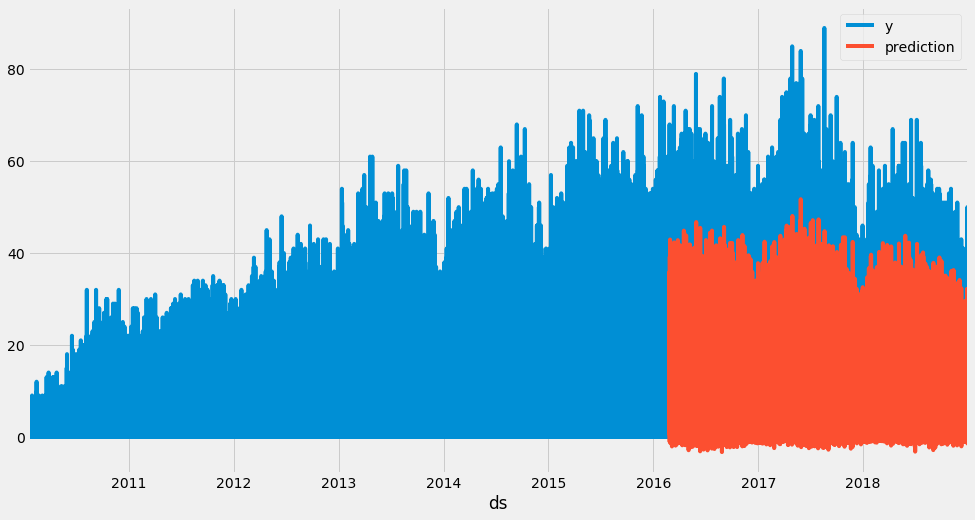

In [51]:
hlstm_predict = hlstm_model.predict(hourly_tor.y.values[np.newaxis, -4*hval_size-1:-hval_size-1, np.newaxis])
pred = pd.DataFrame(hlstm_predict[0,:,0], \
            index=hourly_tor[-4*hval_size:-hval_size].index,
            columns=['prediction'])

fig, ax = plt.subplots()
hourly_tor[:-hval_size].plot(label='observed',ax=ax)
pred.plot(ax=ax)
plt.legend()
plt.show()

In [52]:
rmse_train = math.sqrt(mean_squared_error(hourly_tor[-4*hval_size:-hval_size], pred.prediction))
print("The root mean squared error is {}.".format(rmse_train))

The root mean squared error is 7.349477424151505.


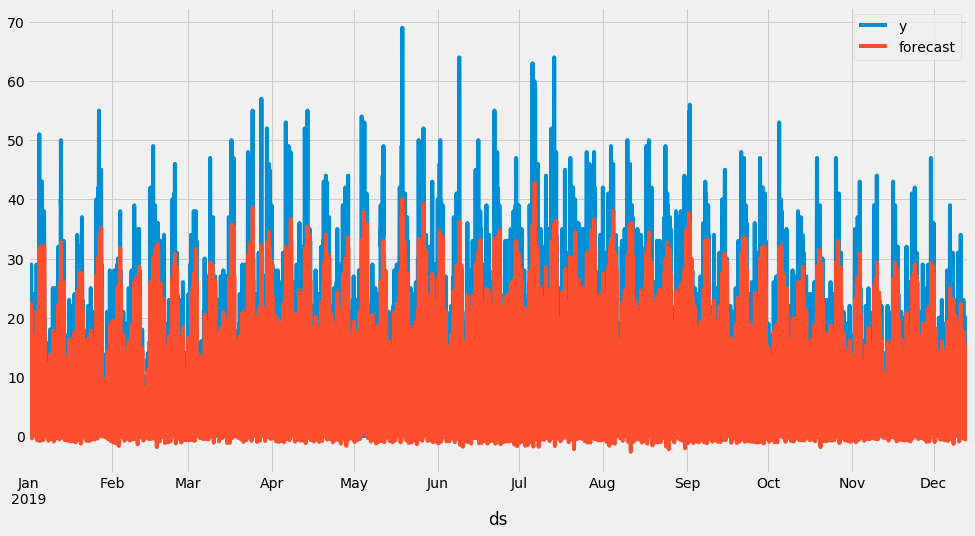

In [53]:
hlstm_forecast = hlstm_model.predict(hourly_tor.y.values[np.newaxis, -hval_size-1:-1, np.newaxis])
fcast = pd.DataFrame(hlstm_forecast[0, : , 0], \
            index=hourly_tor[-hval_size:].index,
            columns=['forecast'])

fig, ax = plt.subplots()
hourly_tor[-hval_size:].plot(ax=ax)
fcast.plot(ax=ax)
plt.legend()
plt.show()

In [54]:
rmse_test = math.sqrt(mean_squared_error(hourly_tor[-hval_size:], fcast))
print("The root mean squared error is {}.".format(rmse_test))

The root mean squared error is 5.926485237319442.


In [55]:
errors = dict()
errors['model'] = []
errors['rmse_train'] = []
errors['rmse_test'] = []
errors['mape'] = []

for row in error_vals:
    errors['model'].append(row[0])
    errors['rmse_train'].append(row[1])
    errors['rmse_test'].append(row[2])
    errors['mape'].append(row[3])

pd.DataFrame(errors)

,model,rmse_train,rmse_test,mape
0,Stateless RNN,101.081575,100.702748,45.747676
1,Sequence-to-sequence,102.287506,113.604627,53.945385
2,Stateful RNN,103.756983,122.293705,58.707674
3,LSTM,103.670160,112.535982,53.064006


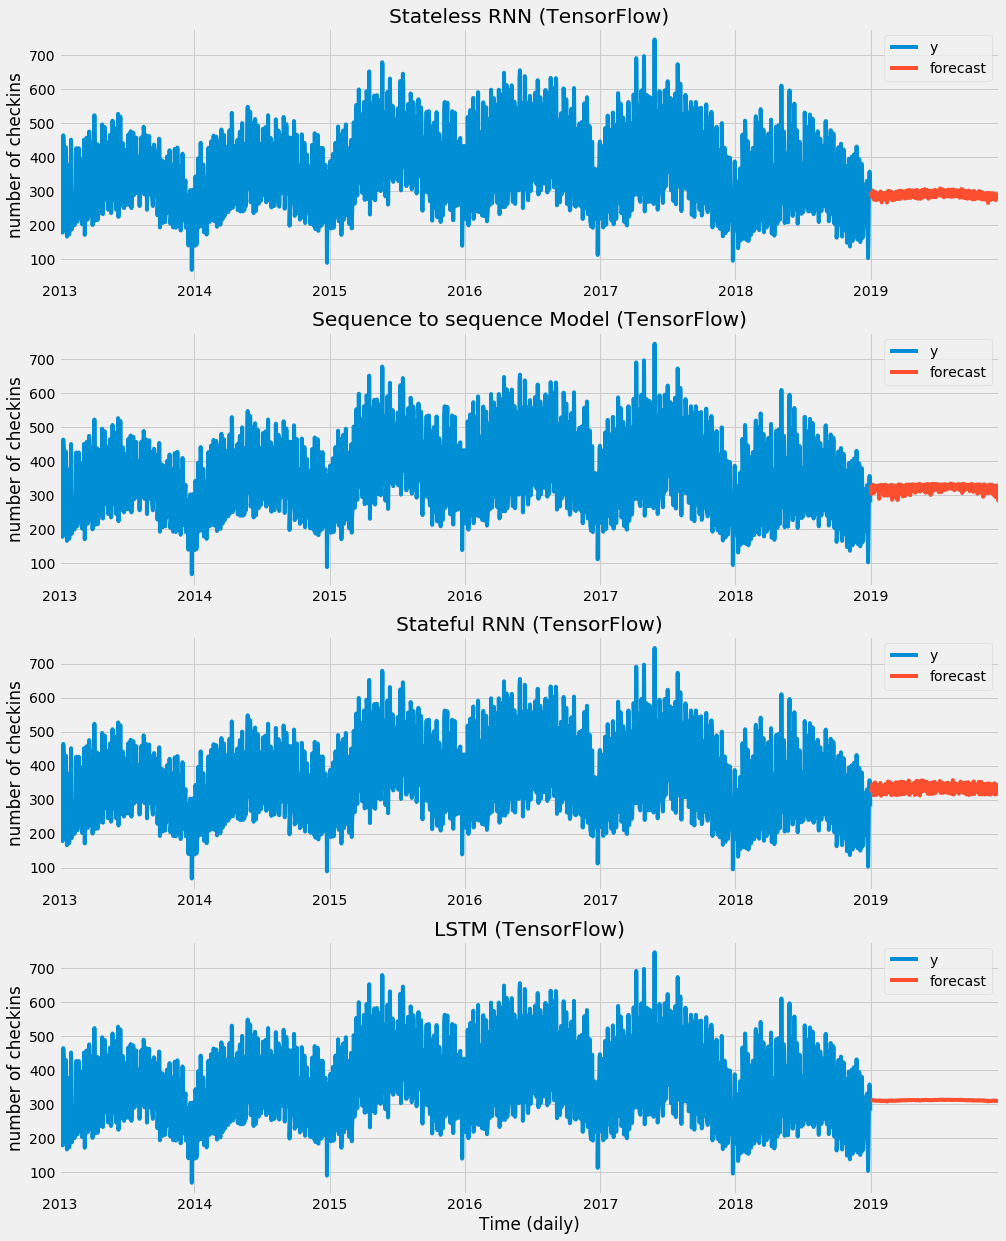

In [56]:
fig,ax = plt.subplots(4,1,figsize=(15,20))

d_train.plot(ax=ax[0], label='daily checkins')
rnn_forecast = model_forecast(rnn_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y, window_size)[:, 0]
fcast = pd.DataFrame(rnn_forecast, \
            index=d_test.index,
            columns=['forecast'])
fcast.plot(ax=ax[0])

d_train.plot(ax=ax[1], label='daily checkins')
s2s_forecast = model_forecast(s2s_model, pd.concat([d_train[-window_size:],d_test[:-1]]).y.values[..., np.newaxis], window_size)[:, 0]
fcast = pd.DataFrame(s2s_forecast, \
            index=d_test.index,
            columns=['forecast'])
fcast.plot(ax=ax[1])

d_train.plot(ax=ax[2], label='daily checkins')
srnn_forecast = srnn_model.predict(daily_tor.y.values[np.newaxis, :, np.newaxis])
fcast = pd.DataFrame(srnn_forecast[0, -val_size-1:-1, 0], \
            index=d_test.index,
            columns=['forecast'])
fcast.plot(ax=ax[2])

d_train.plot(ax=ax[3], label='daily checkins')
lstm_forecast = lstm_model.predict(daily_tor.y.values[np.newaxis, :, np.newaxis])
fcast = pd.DataFrame(lstm_forecast[0, -val_size-1:-1, 0], \
            index=d_test.index,
            columns=['forecast'])
fcast.plot(ax=ax[3])

ax[0].set(title='Stateless RNN (TensorFlow)',xlabel='',ylabel='number of checkins')
ax[1].set(title='Sequence to sequence Model (TensorFlow)',xlabel='',ylabel='number of checkins')
ax[2].set(title='Stateful RNN (TensorFlow)',xlabel='',ylabel='number of checkins')
ax[3].set(title='LSTM (TensorFlow)',xlabel='Time (daily)',ylabel='number of checkins')

plt.show()